https://fehiepsi.github.io/rethinking-numpyro/02-small-worlds-and-large-worlds.html

In [1]:
!pip install -q numpyro arviz

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 2.34.4 requires packaging<22.0dev,>=14.3, but you have packaging 24.1 which is incompatible.
jupyterlab 4.2.4 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.1.0 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
momepy 0.7.2 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
osmnx 1.9.4 requires shapely<2.1,>=2.0, but you have shapely 1.8.5.post1 which is incompatible.
pointpats 2.5.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
spaghetti 1.7.6 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
spopt 0.6.1 requires shapely>=2.0.


jax - newish ml libraries from google
https://theaisummer.com/jax/
numpyro -  probabilistic programming library
https://num.pyro.ai/en/latest/getting_started.html
arviz - Exploratory analysis of Bayesian models
https://python.arviz.org/en/stable/

In [2]:
import os

import arviz as az
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax import random

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoLaplaceApproximation

if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
az.style.use("arviz-darkgrid")
numpyro.set_platform("cpu")

In [3]:
ways = jnp.array([0.0, 3, 8, 9, 0])
ways / jnp.sum(ways)

Array([0.  , 0.15, 0.4 , 0.45, 0.  ], dtype=float32)

In [4]:
# define grid
p_grid = jnp.linspace(start=0, stop=1, num=20)

# define prior
prior = jnp.repeat(1, 20)

# compute likelihood at each value in grid
likelihood = jnp.exp(dist.Binomial(total_count=9, probs=p_grid).log_prob(6))

# compute product of likelihood and prior
unstd_posterior = likelihood * prior

# standardize the posterior, so it sums to 1
posterior = unstd_posterior / jnp.sum(unstd_posterior)

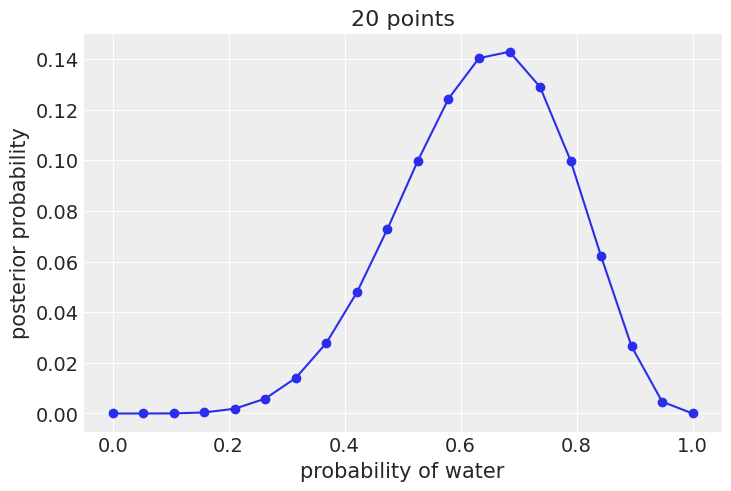

In [5]:
plt.plot(p_grid, posterior, "-o")
plt.xlabel("probability of water")
plt.ylabel("posterior probability")
plt.title("20 points")
plt.show()

In [6]:
prior = jnp.where(p_grid < 0.5, 0, 1)


In [7]:
# compute likelihood at each value in grid
likelihood = jnp.exp(dist.Binomial(total_count=9, probs=p_grid).log_prob(6))

# compute product of likelihood and prior
unstd_posterior = likelihood * prior

# standardize the posterior, so it sums to 1
posterior = unstd_posterior / jnp.sum(unstd_posterior)

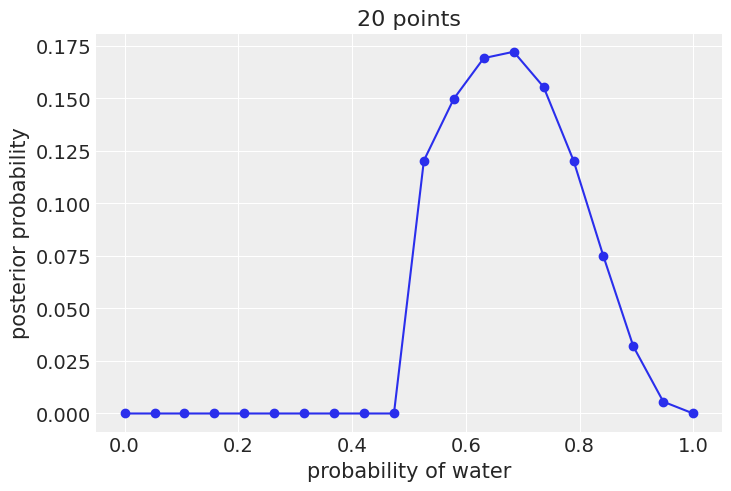

In [8]:
plt.plot(p_grid, posterior, "-o")
plt.xlabel("probability of water")
plt.ylabel("posterior probability")
plt.title("20 points")
plt.show()

In [9]:
prior = jnp.exp(-5 * abs(p_grid - 0.5))

In [10]:
# compute likelihood at each value in grid
likelihood = jnp.exp(dist.Binomial(total_count=9, probs=p_grid).log_prob(6))

# compute product of likelihood and prior
unstd_posterior = likelihood * prior

# standardize the posterior, so it sums to 1
posterior = unstd_posterior / jnp.sum(unstd_posterior)

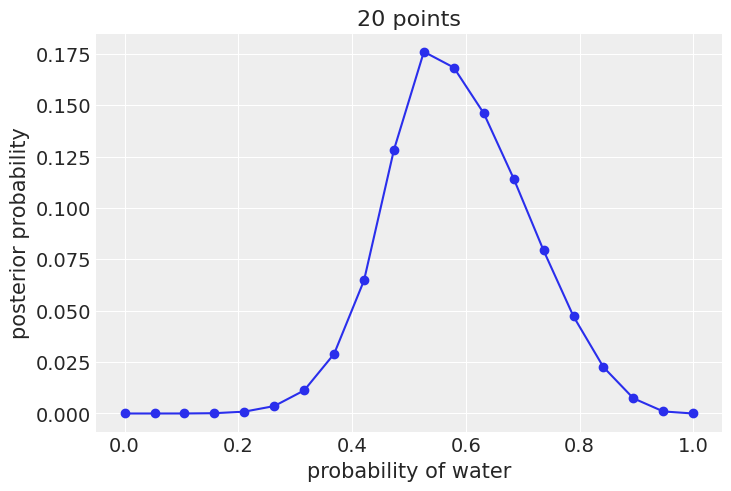

In [11]:
plt.plot(p_grid, posterior, "-o")
plt.xlabel("probability of water")
plt.ylabel("posterior probability")
plt.title("20 points")
plt.show()